# BLOOM Carbon Footprint : An Analysis of the logs

# Introduction

This notebook aims to analyse the SLURM logs of the experiments run on Jean Zay during the BigScience Project.
They were obtained using the `jobs_info.py` script.

## Data
The logs can be found in the Project-end folder.

## TODO
- Add source for grams of Co2 vs kWh, see TODO in code
- Add explanation about CPU power and why it is << to GPU power and we choose to ignore it
- Refactor other trainings, eval, tokenizers
- Do we need to keep # DATA PROCESSING, DOWNLOADING, DEDUPLICATION ?

# Modules loading and configuration

In [92]:
import os
import matplotlib
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 1000)  # or 1000
pd.set_option('display.max_rows', 1000)  # or 1000
pd.set_option('display.max_colwidth', None) 
pd.options.plotting.backend = "plotly"

# Data loading and pre-processing

In [93]:
# Read files into a single DataFrame
directory = "Project-end/"
file_paths = [directory+x for x in os.listdir(directory) if x.endswith("logs.txt")]
df_list = [pd.read_csv(filename, sep="|", header=None).assign(file=filename.split("/")[1]) for filename in file_paths]
df = pd.concat(df_list, ignore_index=True)
df.columns= ['job_id', 'num_V100_32GB', 'num_V100_16GB', 'num_A100_40GB', 'num_A100_80GB', \
             'alloc_cpu', 'alloc_mem', 'alloc_energy', 'partition', 'group', 'elapsed',\
              'qos','jobname', 'start', 'end', 'workdir', 'account' ,'file']

# Delete useless fields
df=df.drop(['alloc_energy','workdir'], axis=1)

# Cast datetimes as such
df['start'] = pd.to_datetime(df['start'])
df['end'] = pd.to_datetime(df['end'],  errors='coerce')

# Make our own duration as elapsed field is sometimes buggy
df['duration'] = df['end'] - df['start']

# Show example of elapsed time being bogus
# df['elapsed'] = pd.to_timedelta(df['elapsed'])
# df['duration_diff']= df['duration'] - df['elapsed']
# df=df[df.columns[[0,1,2,3,4,5,6,7,8,12,13,9,16,17,10,11,14,15]]] 
# df[df['duration_diff']>pd.to_timedelta(0)].head(3)

# Compute GPU hours per hardware type
durations_in_hours = (df['duration'] / np.timedelta64(1, 's') / 3600)
df['hours_V100_32GB'] = df['num_V100_32GB'] * durations_in_hours
df['hours_V100_16GB'] = df['num_V100_16GB'] * durations_in_hours
df['hours_A100_40GB'] = df['num_A100_40GB'] * durations_in_hours
df['hours_A100_80GB'] = df['num_A100_80GB'] * durations_in_hours


# Data augmentation with external sources

In [94]:
# Compute GPU power for each job, assuming running at 100% TDP, using hardware info from JZ documentation --> http://www.idris.fr/eng/jean-zay/cpu/jean-zay-cpu-hw-eng.html
df['gpu_power_watts_hours'] = df['hours_V100_32GB'] * 300 # https://resources.nvidia.com/en-us-virtualization-and-gpus/v100-datasheet
df['gpu_power_watts_hours'] += df['hours_V100_16GB'] * 300 # https://resources.nvidia.com/en-us-virtualization-and-gpus/v100-datasheet
df['gpu_power_watts_hours'] += df['hours_A100_40GB'] * 250 # https://www.nvidia.com/content/dam/en-zz/Solutions/Data-Center/a100/pdf/A100-PCIE-Prduct-Brief.pdf
df['gpu_power_watts_hours'] += df['hours_A100_80GB'] * 400 # https://www.nvidia.com/content/dam/en-zz/Solutions/Data-Center/a100/pdf/nvidia-a100-datasheet-nvidia-us-2188504-web.pdf
carbon_g_per_W = 0.057 # TODO add source of this data point

df[df['gpu_power_watts_hours']>0].head(3)

job_id  num_V100_32GB  num_V100_16GB  num_A100_40GB  num_A100_80GB  \
1     1591866              0              4              0              0   
5     2189133              0              4              0              0   
1976   331271              0              1              0              0   

      alloc_cpu alloc_mem partition     group   elapsed         qos  \
1          20.0       40G   gpu_p13  genhug01  00:02:11  qos_gpu-t3   
5          42.0       84G   gpu_p13  genhug01  00:38:54  qos_gpu-t3   
1976       10.0       20G   gpu_p13  genhug01  01:55:02  qos_gpu-t3   

                          jobname               start                 end  \
1     second_lm_balanced_prompted 2021-05-15 00:00:15 2021-05-15 00:02:26   
5                            bash 2021-06-03 15:52:07 2021-06-03 16:31:01   
1976                         bash 2021-07-01 12:10:45 2021-07-01 14:05:47   

      account                               file        duration  \
1     ajs@gpu  2022_08_25_victorsanh_jz_logs.txt 0 days 00:02:11   
5     ajs@gpu  2022_08_25_victorsanh_jz_logs.txt 0 days 00:38:54   
1976  six@gpu  2022_08_25_victorsanh_jz_logs.txt 0 days 01:55:02   

      hours_V100_32GB  hours_V100_16GB  hours_A100_40GB  hours_A100_80GB  \
1                 0.0         0.145556              0.0              0.0   
5                 0.0         2.593333              0.0              0.0   
1976              0.0         1.917222              0.0              0.0   

      gpu_power_watts_hours  
1                 43.666667  
5                778.000000  
1976             575.166667

In [95]:
df.shape

(177192, 22)

# Data sanity checks

In [96]:
# Compare detailled logs vs. snapshot of quotas
print(df.hours_A100_80GB.sum()) # Capturing 99.3% of quotas, looking fine
print(df.hours_V100_32GB.sum() + df.hours_V100_16GB.sum()) # Capturing 115% of quotas, maybe quotas does not count all partitions?
df_v100 = df[(df['hours_V100_32GB']>0) | (df['hours_V100_16GB']>0)]
df_v100.partition.value_counts()

1242577.3975000002
2363314.732777778


gpu_p13    26142
gpu_p2      8338
gpu_p2l       31
gpu_p2s       25
Name: partition, dtype: int64

In [97]:
# Show number of runs per input file
df['file'].value_counts()

2022_08_02_thomas_wang_jz_logs.txt      45967
2022_08_08_luciles_logs.txt             39031
2022_08_01_stas_jz_logs.txt             38111
2022_08_25_victorsanh_jz_logs.txt       29049
2022-08-24_tvn_jz_logs.txt              11385
2022_08_01_muennighoff_jz_logs.txt       5139
2022_08_01_pierrec_jz_logs.txt           4813
new_hugo_laurencon_jz_logs.txt           2185
2022_08_24_thomwolf_jz_logs.txt           760
2022_08_02_younesb_jz_logs.txt            603
2022_08_24_roman_castagne_logs.txt        110
2022_08_01_sylvainv_jz_logs.txt            34
2022_08_08_danielhesslow_jz_logs.txt        5
Name: file, dtype: int64

# All Runs analysis

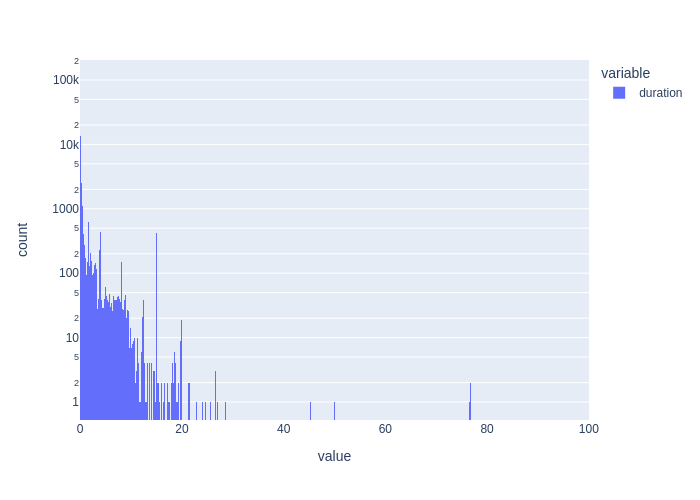

In [98]:
# Plot the distribution of runs length
durations_in_hours = (df['duration'] / np.timedelta64(1, 's') / 3600)
durations_in_hours_for_hist = durations_in_hours [(durations_in_hours < 1000)] # Remove few run of 200days...
histogram = durations_in_hours_for_hist.hist(log_y=True)

histogram.show("png") # Force png format for static view in GitHub, comment out when working locally
histogram.show()

In [99]:
# Carbon footprint estimation for GPUs only
carbon_g_per_W = 0.057 # TODO add source of this data point
total_gpus_hours = df.hours_A100_80GB.sum()  + df.hours_V100_32GB.sum() +df.hours_V100_16GB.sum()
print(f"All experiments lasted a combined {df.duration.sum()},\
 using {(total_gpus_hours/1e6).round(2)} millions hours of GPUs,\
 representing an electrical consumption of {(df.gpu_power_watts_hours.sum() / 1000).round(1)} kW \
 or {((df.gpu_power_watts_hours.sum() * carbon_g_per_W) /1e6).round(2)} tons of Co2e emitted.")

All experiments lasted a combined 5816 days 13:22:40, using 3.61 millions hours of GPUs, representing an electrical consumption of 1206025.4 kW  or 68.74 tons of Co2e emitted.


# Main Bloom Training

In [100]:
# Select only final training runs
bloomdf = df[df['jobname'] == 'tr11-176B-ml']
bloomdf.head(3)

job_id  num_V100_32GB  num_V100_16GB  num_A100_40GB  num_A100_80GB  \
31224  509729              0              0              0             32   
42728  406772              0              0              0            384   
84230  417634              0              0              0            384   

       alloc_cpu alloc_mem partition     group   elapsed         qos  \
31224      512.0     1875G    gpu_p5  genhug01  00:00:46  qos_gpu-gc   
42728     6144.0    22500G    gpu_p5  genhug01  00:00:01  qos_gpu-gc   
84230     6144.0    22500G    gpu_p5       six  00:01:49  qos_gpu-gc   

            jobname               start                 end   account  \
31224  tr11-176B-ml 2022-03-15 23:40:35 2022-03-15 23:41:21  six@a100   
42728  tr11-176B-ml 2022-06-12 00:31:16 2022-06-12 00:31:17       NaN   
84230  tr11-176B-ml 2022-03-11 18:09:15 2022-03-11 18:11:04       NaN   

                                     file        duration  hours_V100_32GB  \
31224          2022-08-24_tvn_jz_logs.txt 0 days 00:00:46              0.0   
42728      new_hugo_laurencon_jz_logs.txt 0 days 00:00:01              0.0   
84230  2022_08_02_thomas_wang_jz_logs.txt 0 days 00:01:49              0.0   

       hours_V100_16GB  hours_A100_40GB  hours_A100_80GB  \
31224              0.0              0.0         0.408889   
42728              0.0              0.0         0.106667   
84230              0.0              0.0        11.626667   

       gpu_power_watts_hours  
31224             163.555556  
42728              42.666667  
84230            4650.666667

In [101]:
bloomdf.shape

(398, 22)

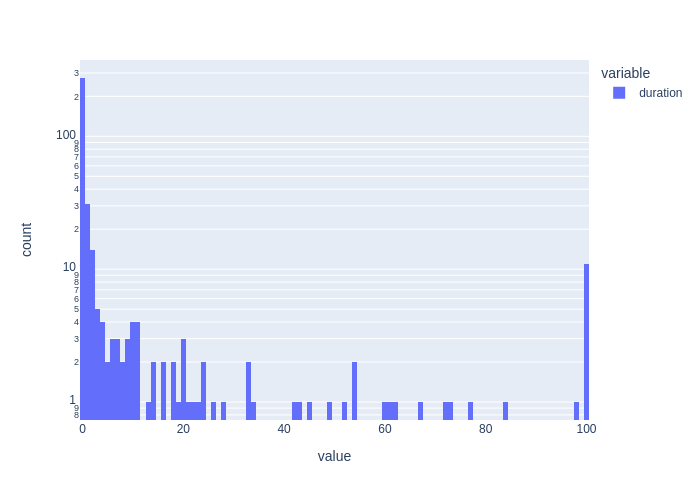

In [102]:
# Distribution of runs length
durations_in_hours = (bloomdf['duration'] / np.timedelta64(1, 's') / 3600)
histogram = durations_in_hours.hist(nbins=100, log_y=True)

histogram.show("png") # Force png format for static view in GitHub, comment out when working locally
histogram.show()

In [103]:
# Decomposition of runs per number of GPUs used
bloomdf['num_A100_80GB'].value_counts()
#bloomdf['num_A100_80GB'].hist(nbins=int(bloomdf['num_A100_80GB'].max()))

384    316
192     27
0       20
144     13
288      8
1        5
32       4
8        2
16       2
216      1
Name: num_A100_80GB, dtype: int64

In [104]:
# Carbon footprint estimation for GPUs only
carbon_g_per_W = 0.057
print(f"Final training lasted {bloomdf.duration.sum()},\
 using {(bloomdf.hours_A100_80GB.sum()/1e6).round(2)} millions hours of GPUs,\
 representing an electrical consumption of {(bloomdf.gpu_power_watts_hours.sum() / 1000).round(1)} kW \
 or {((bloomdf.gpu_power_watts_hours.sum() * carbon_g_per_W) /1e6).round(2)} tons of Co2e emitted.")

Final training lasted 118 days 05:40:42, using 1.08 millions hours of GPUs, representing an electrical consumption of 433195.8 kW  or 24.69 tons of Co2e emitted.


In [105]:
177192-398

176794

In [106]:
df.drop(bloomdf.index, axis=0, inplace=True)
df.shape

(176794, 22)

# Other Trainings

### All trainings

In [107]:
#traindf = df[df['jobname'].str.startswith('tr')]

In [108]:
traindf = df[df['jobname'].str.contains("^(?:tr|125M|181M|1B3|350M|760M|prefix)")]
traindf = traindf[~traindf['jobname'].str.contains('sync')]
traindf = traindf[~traindf['jobname'].str.contains('move')]
traindf = traindf[~traindf['jobname'].str.contains('eval')]
traindf = traindf[~traindf['jobname'].str.contains('tokenizer')]
traindf.shape

(12066, 22)

In [109]:
traindf['jobname'].value_counts()

tr8-104B-slurm-status                                     3596
tr6e-1B3-prefix-lm                                        1435
tr6f-1B3-prefix-lm                                        1431
tr6g-1B3-prefix-lm                                        1008
tr1-13B-slurm-status                                       757
tr7d-1B3-alibi                                             433
tr11                                                       302
tr11-200B-ml                                               204
tr8-104B                                                   153
tr11f-6B3-ml                                               146
tr8b-104B-cl                                               131
tr8b-104B-bnb                                              123
tr8b-104B-emb-norm                                         117
tr13f-6B3-ml-t0                                            102
tr3e-1B3-c4.slurm                                           98
prefix-lm-1B3.slurm                                    

In [114]:
traindf.duration.sum()

Timedelta('778 days 20:14:39')

In [115]:
traindf.gpu_power_watts_hours.sum()/ 1000

645564.7699166667

In [116]:
# Carbon footprint estimation for GPUs only
carbon_g_per_W = 0.057
print(((traindf.gpu_power_watts_hours.sum() * carbon_g_per_W) /1e6).round(2))

36.8


### 104B training

In [125]:
tr8df = traindf[traindf['jobname'].str.contains('104B')]
tr8df.shape

(4286, 23)

In [126]:
tr8df.gpu_power_watts_hours.sum()/ 1000

266522.1744444444

In [120]:
# Carbon footprint estimation for GPUs only
carbon_g_per_W = 0.057
print(((tr8df.gpu_power_watts_hours.sum() * carbon_g_per_W) /1e6).round(2))

15.19


In [130]:
traindf.drop(tr8df.index, axis=0,inplace=True)
traindf.shape

(7780, 23)

### BLOOM experimentation

In [123]:
tr11df = traindf[traindf['jobname'].str.contains('tr11')]
tr11df.shape

(991, 23)

In [124]:
tr11df.gpu_power_watts_hours.sum()/ 1000

121462.11130555555

In [122]:
# Carbon footprint estimation for GPUs only
carbon_g_per_W = 0.057
print(((tr11df.gpu_power_watts_hours.sum() * carbon_g_per_W) /1e6).round(2))

6.92


In [131]:
traindf.drop(tr11df.index, axis=0,inplace=True)
traindf.shape

(6789, 23)

### 1B model

In [133]:
tr1Bdf = traindf[traindf['jobname'].str.contains('1B3')]
tr1Bdf.shape

(5626, 23)

In [134]:
tr1Bdf.gpu_power_watts_hours.sum()/ 1000

158972.832

In [142]:
# Carbon footprint estimation for GPUs only
carbon_g_per_W = 0.057
print(((tr1Bdf.gpu_power_watts_hours.sum() * carbon_g_per_W) /1e6).round(2))

9.06


In [136]:
traindf.drop(tr1Bdf.index, axis=0,inplace=True)
traindf.shape

(1163, 23)

### 13B model

In [140]:
tr13Bdf = traindf[traindf['jobname'].str.contains('13B')]
tr13Bdf.shape

(861, 23)

In [141]:
tr13Bdf.gpu_power_watts_hours.sum()/ 1000

87210.676

In [143]:
# Carbon footprint estimation for GPUs only
carbon_g_per_W = 0.057
print(((tr13Bdf.gpu_power_watts_hours.sum() * carbon_g_per_W) /1e6).round(2))

4.97


In [144]:
traindf.drop(tr13Bdf.index, axis=0,inplace=True)
traindf.shape

(302, 23)

### Others

In [145]:
traindf.gpu_power_watts_hours.sum()/ 1000

11396.976166666667

In [147]:
# Carbon footprint estimation for GPUs only
carbon_g_per_W = 0.057
print(((traindf.gpu_power_watts_hours.sum() * carbon_g_per_W) /1e6).round(2))

0.65


In [139]:
traindf['jobname'].value_counts()

tr1-13B-slurm-status                          757
tr13f-6B3-ml-t0                               102
tr1-13B-round3                                 70
prefix-lm.slurm                                63
125M-v2.slurm                                  28
tr1-13B-round1.slurm                           20
760M.slurm                                     18
prefix-lm-350M.slurm                           15
tr13f-6B3-ml-t0-memcheck                       14
tr1-13B-round3.slurm                           14
training                                       12
350M.slurm                                      9
181M.slurm                                      7
350M-v2.slurm                                   7
train_tokenize_v2_toy                           5
350M-alibi.slurm                                4
train_tokenize_v2                               4
350M-rotary.slurm                               4
760M-pile.slurm                                 2
350M-alibi-extrapolation                        2


In [24]:
176794-11892

164902

In [25]:
df.drop(traindf.index, axis=0,inplace=True)
df.shape

(164902, 22)

# Eval

In [26]:
evaldf = df[df['jobname'].str.contains('eval')]
evaldf.shape

(16041, 22)

In [27]:
evaldf['account'].value_counts()

six@gpu     8042
six@a100    2466
six@v100      25
six@cpu        6
Name: account, dtype: int64

In [28]:
evaldf['jobname'].value_counts()

eval-tr3                                                                            3643
evaluate_t0                                                                         2337
eval_finetune-t5-xxl-lm-d4-091621                                                    747
score_eval_finetune-t5-xxl-lm-d4-091621                                              694
score_eval_finetune-t5-xxl-lm-d4-all-091621                                          671
eval_baseline                                                                        534
eval_finetune-t5-xxl-lm-d4-all-091621                                                531
eval_finetune-t5-xl-lm-d4-091621                                                     530
eval_finetune-t5-xxl-lm-d4-091621-512                                                530
eval_finetune-t5-xxl-lm-d4-gpt-091621                                                514
bs-eval-bloom-176b                                                                   504
score_eval_finetune-t

In [29]:
evaldf.gpu_power_watts_hours.sum()/1000

43172.10413888889

In [30]:
carbon_g_per_W = 0.057
print(((evaldf.gpu_power_watts_hours.sum() * carbon_g_per_W) /1e6).round(2))

2.46


In [31]:
164902-16041

148861

In [32]:
df.drop(evaldf.index, axis=0,inplace=True)
df.shape

(148861, 22)

# DATA PROCESSING, DOWNLOADING, DEDUPLICATION

In [33]:
datadf = df[df['jobname'].str.contains('data')]
datadf.shape

(29407, 22)

In [34]:
datadf['account'].value_counts()

six@cpu     13933
six@gpu       429
ajs@gpu        27
ajs@cpu         5
ajs@v100        2
Name: account, dtype: int64

In [35]:
datadf['jobname'].value_counts()

download_all_catalogue_datasets                                           4507
pseudo_crawl_clean_dataset                                                4282
preprocess_all_catalogue_datasets                                         3146
modelling-metadata-c4-dataset-toy-add-metadata-full                       2925
modelling-metadata-c4-dataset-toy-add-website-desc                        2844
modelling-metadata-c4-dataset-export-to-jsonlines                         2801
modelling-metadata-c4-dataset-toy-add-metadata-full-v3                    2761
filter_short_document_all_catalogue_datasets                              1900
deduplicate_all_catalogue_datasets                                        1121
modelling-metadata-c4-dataset-toy-add-metadata-full-v2                     873
convert_datasets_to_jsonl                                                  609
yong-download_dataset                                                      373
modelling-metadata-c4-dataset-toy-add-metadata      

In [36]:
datadf.gpu_power_watts_hours.sum()/1000

197.03794444444443

In [37]:
carbon_g_per_W = 0.057
print(((datadf.gpu_power_watts_hours.sum() * carbon_g_per_W) /1e6).round(2))

0.01


In [38]:
148861- 29407

119454

In [39]:
df.drop(datadf.index, axis=0,inplace=True)
df.shape

(119454, 22)

# OTHER 

In [40]:
df['account'].value_counts()

six@cpu     40322
six@gpu     11581
six@v100     3812
six@a100     1666
ajs@cpu       716
ajs@gpu        61
ajs@v100       53
six             1
Name: account, dtype: int64

In [41]:
df.sort_values('gpu_power_watts_hours',ascending=False).head()

job_id  num_V100_32GB  num_V100_16GB  num_A100_40GB  num_A100_80GB  \
131655  1302634              0            512              0              0   
43384   1312985              0              2              0              0   
131653  1291790              0            512              0              0   
29088   2189034            128              0              0              0   
131665  1331641              0            512              0              0   

        alloc_cpu alloc_mem partition     group       elapsed         qos  \
131655    10240.0       20T   gpu_p13  genhug01      20:00:24  qos_gpu-t3   
43384        40.0       80G   gpu_p13       six  200-21:54:53  qos_gpu-t3   
131653    10240.0       20T   gpu_p13  genhug01      15:50:05  qos_gpu-t3   
29088      2560.0        5T   gpu_p13  genhug01    2-02:00:03  qos_gpu-t4   
131665    10240.0       20T   gpu_p13  genhug01      11:31:43  qos_gpu-t3   

          jobname               start                 end  account  \
131655  v16x4Dist 2021-05-06 18:54:15 2021-05-07 14:54:39      NaN   
43384   gpt.slurm 2021-09-30 14:07:30 2022-04-19 12:02:23      NaN   
131653  v16x4Dist 2021-05-05 23:50:32 2021-05-06 15:40:37      NaN   
29088        bash 2021-06-04 07:46:05 2021-06-06 09:46:08  ajs@gpu   
131665  v16x4Dist 2021-05-07 15:05:26 2021-05-08 02:37:09      NaN   

                                      file          duration  hours_V100_32GB  \
131655     2022_08_24_thomwolf_jz_logs.txt   0 days 20:00:24         0.000000   
43384   2022_08_02_thomas_wang_jz_logs.txt 200 days 21:54:53         0.000000   
131653     2022_08_24_thomwolf_jz_logs.txt   0 days 15:50:05         0.000000   
29088           2022-08-24_tvn_jz_logs.txt   2 days 02:00:03      6400.106667   
131665     2022_08_24_thomwolf_jz_logs.txt   0 days 11:31:43         0.000000   

        hours_V100_16GB  hours_A100_40GB  hours_A100_80GB  \
131655     10243.413333              0.0              0.0   
43384       9643.829444              0.0              0.0   
131653      8107.377778              0.0              0.0   
29088          0.000000              0.0              0.0   
131665      5902.648889              0.0              0.0   

        gpu_power_watts_hours  
131655           3.073024e+06  
43384            2.893149e+06  
131653           2.432213e+06  
29088            1.920032e+06  
131665           1.770795e+06

In [45]:
s = df.groupby('jobname')['gpu_power_watts_hours'].sum()
s.sort_values(ascending=False)

jobname
v16x4Dist                                     1.493907e+07
prefix-lm-1B3.slurm                           1.183401e+07
v32x4Dist                                     7.962811e+06
bash                                          7.960577e+06
finetuned_ckpt                                5.398380e+06
                                                  ...     
pile-jsonl-to-meg-alpha                       0.000000e+00
pile-all-jsonl-to-meg-alpha                   0.000000e+00
pigz                                          0.000000e+00
parse_1b_natural_questions_Toy_reduced_all    0.000000e+00
-                                             0.000000e+00
Name: gpu_power_watts_hours, Length: 3047, dtype: float64

In [46]:
df.gpu_power_watts_hours.sum()/1000

96465.10266666666

In [47]:
carbon_g_per_W = 0.057
print(((df.gpu_power_watts_hours.sum() * carbon_g_per_W) /1e6).round(2))

5.5
